In [23]:
!pip install --user -r requirements.txt

  Using cached matplotlib-3.8.2-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
Using cached matplotlib-3.8.2-cp311-cp311-win_amd64.whl (7.6 MB)


In [2]:
import os
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from PIL import Image
import scipy.io
import warnings
import matplotlib.pyplot as plt

In [3]:
# --- Configuration ---
video_name = "Bearpark_climbing"
base_path = "."

# Define paths using os.path.join for cross-platform compatibility
data_path = os.path.join(base_path, "data", "SumMe")
video_path = os.path.join(data_path, "videos", f"{video_name}.mp4")
frame_dir = os.path.join(data_path, "frames", video_name)
feature_dir = os.path.join(base_path, "features", video_name)
summary_dir = os.path.join(base_path, "summaries")
gt_path = os.path.join(data_path, "GT")
    
# Create directories if they don't exist
os.makedirs(frame_dir, exist_ok=True)
os.makedirs(feature_dir, exist_ok=True)
os.makedirs(summary_dir, exist_ok=True)

In [4]:
# --- Feature Extraction Functions ---
# --- 0. Frame Extraction ---
def extract_frames(video_path, output_dir, fps=5):
    """Extract frames from a video at a given FPS."""
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    frame_count = 0
    saved_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save frame at target FPS
        if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) // fps == 0:
            cv2.imwrite(f"{output_dir}/frame_{saved_count:04d}.jpg", frame)
            saved_count += 1
        frame_count += 1
    
    cap.release()
    print(f"Extracted {saved_count} frames to {output_dir}")

# --- 1. ResNet Features ---
def extract_resnet_features(frame_dir):
    # Updated to use weights parameter instead of pretrained
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).eval()
    layers = list(model.children())[:-1]  # Remove final FC layer
    model = torch.nn.Sequential(*layers)
    transform = Compose([
        Resize((224, 224)), 
        ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    features = []
    for frame_path in sorted(os.listdir(frame_dir)):
        frame = cv2.imread(f"{frame_dir}/{frame_path}")
        frame_pil = Image.fromarray(frame)
        frame = transform(frame_pil).unsqueeze(0)
        with torch.no_grad():
            feat = model(frame).flatten()
        features.append(feat.numpy())
    return np.array(features)

# --- 2. Optical Flow ---
def extract_optical_flow(frame_dir):
    frame_paths = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])
    if not frame_paths:
        raise ValueError(f"No frames found in {frame_dir}")
    
    prev_frame = cv2.cvtColor(cv2.imread(f"{frame_dir}/{frame_paths[0]}"), cv2.COLOR_BGR2GRAY)
    flow_features = [0.0]  # First frame has no flow
    
    for frame_path in frame_paths[1:]:
        next_frame = cv2.cvtColor(cv2.imread(f"{frame_dir}/{frame_path}"), cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_features.append(np.linalg.norm(flow).mean())
        prev_frame = next_frame
    
    return np.array(flow_features).reshape(-1, 1)

# --- 3. Color Histograms ---
def extract_color_histograms(frame_dir, bins=16):
    histograms = []
    for frame_path in sorted(os.listdir(frame_dir)):
        frame = cv2.imread(f"{frame_dir}/{frame_path}")
        hist = cv2.calcHist([frame], [0, 1, 2], None, [bins]*3, [0, 256]*3)
        histograms.append(cv2.normalize(hist, hist).flatten())
    return np.array(histograms)

In [5]:
# Step 0: Extract frames first (NEW)
print(f"Extracting frames from {video_path}...")
extract_frames(video_path, frame_dir, fps=30)
    
# Step 1-3: Extract and save features
os.makedirs(feature_dir, exist_ok=True)
    
# ResNet
resnet_feats = extract_resnet_features(frame_dir)
np.save(f"{feature_dir}/resnet_{video_name}.npy", resnet_feats)
    
# Optical Flow
flow_feats = extract_optical_flow(frame_dir)
np.save(f"{feature_dir}/flow_{video_name}.npy", flow_feats)
    
# Color Histograms
color_feats = extract_color_histograms(frame_dir)
np.save(f"{feature_dir}/color_{video_name}.npy", color_feats)
    
print(f"Features saved to {feature_dir}/")

Extracting frames from .\data\SumMe\videos\Saving_dolphines.mp4...
Extracted 6683 frames to .\data\SumMe\frames\Saving_dolphines
Features saved to .\features\Saving_dolphines/


In [6]:
# --- Clustering Functions ---

def load_features(video_name, feature_dir="features"):
    """Load all precomputed features for a video."""
    resnet = np.load(f"{feature_dir}/resnet_{video_name}.npy")
    flow = np.load(f"{feature_dir}/flow_{video_name}.npy")
    color = np.load(f"{feature_dir}/color_{video_name}.npy")
    return resnet, flow, color

def fuse_features(resnet, flow, color):
    """Combine and normalize features."""
    scaler = MinMaxScaler()
    resnet_norm = scaler.fit_transform(resnet)
    flow_norm = scaler.fit_transform(flow)
    color_norm = scaler.fit_transform(color)
    return np.concatenate([resnet_norm, flow_norm, color_norm], axis=1)

def temporal_kmeans(features, n_clusters=15, temporal_weight=0.1):
    """K-means with temporal penalty."""
    n_frames = len(features)
    time_indices = np.arange(n_frames).reshape(-1, 1) / n_frames  # Normalized time
    
    # Combine features with time indices
    features_with_time = np.concatenate([features, temporal_weight * time_indices], axis=1)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_with_time)
    return labels, kmeans.cluster_centers_

def select_keyframes(features, labels, centroids):
    """Select frames closest to each cluster centroid."""
    keyframes = []
    for i in range(len(centroids)):
        cluster_mask = (labels == i)
        if not np.any(cluster_mask):
            continue
        cluster_features = features[cluster_mask]
        distances = np.linalg.norm(cluster_features - centroids[i], axis=1)
        keyframe_idx = np.argmin(distances)
        keyframes.append(np.where(cluster_mask)[0][keyframe_idx])
    return sorted(keyframes)

In [7]:
# 1. Load features
resnet, flow, color = load_features(video_name, feature_dir)
    
# 2. Fuse features
fused_features = fuse_features(resnet, flow, color)
    
# 3. Cluster with temporal awareness
n_clusters = int(0.15 * len(fused_features))
labels, centroids = temporal_kmeans(fused_features, n_clusters, temporal_weight=0.1)
    
# 4. Select keyframes
keyframes = select_keyframes(fused_features, labels, centroids[:, :-1])  # Exclude time dimension
    
print(f"Selected keyframes: {keyframes}")
np.save(f"{feature_dir}/keyframes_{video_name}.npy", keyframes)

Selected keyframes: [np.int64(6), np.int64(18), np.int64(32), np.int64(53), np.int64(65), np.int64(85), np.int64(99), np.int64(110), np.int64(129), np.int64(139), np.int64(149), np.int64(162), np.int64(188), np.int64(201), np.int64(221), np.int64(229), np.int64(235), np.int64(249), np.int64(268), np.int64(279), np.int64(290), np.int64(307), np.int64(322), np.int64(349), np.int64(367), np.int64(389), np.int64(397), np.int64(417), np.int64(435), np.int64(461), np.int64(474), np.int64(490), np.int64(508), np.int64(524), np.int64(543), np.int64(561), np.int64(577), np.int64(592), np.int64(609), np.int64(625), np.int64(635), np.int64(644), np.int64(653), np.int64(662), np.int64(677), np.int64(690), np.int64(704), np.int64(714), np.int64(724), np.int64(738), np.int64(766), np.int64(783), np.int64(810), np.int64(823), np.int64(834), np.int64(843), np.int64(865), np.int64(882), np.int64(901), np.int64(912), np.int64(927), np.int64(941), np.int64(953), np.int64(966), np.int64(983), np.int64(999

In [8]:
# --- Evaluation Functions ---

def resample_summary(summary, target_length):
    """Resamples summary to target_length using linear interpolation"""
    source_indices = np.linspace(0, len(summary)-1, num=target_length, dtype=int)
    return summary[source_indices]

def evaluate_summary(summary_selection, video_name, gt_path):
    """
    Enhanced evaluation combining summe.py logic with frame resampling
    Returns: f_measure, summary_length
    """
    # Load GT data
    gt_file = os.path.join(gt_path, f"{video_name}.mat")
    gt_data = scipy.io.loadmat(gt_file)
    user_score = gt_data['user_score']  # Shape: (n_frames_GT, n_users)
    nFrames = user_score.shape[0]
    
    # Convert input to numpy array if needed
    if not isinstance(summary_selection, np.ndarray):
        summary_selection = np.array(summary_selection)
    
    # Handle frame length mismatch
    if len(summary_selection) != nFrames:
        orig_len = len(summary_selection)
        if len(summary_selection) < nFrames:
            warnings.warn(f'Resampling summary from {orig_len} to {nFrames} frames')
            summary_selection = resample_summary(summary_selection, nFrames)
        else:
            warnings.warn(f'Cropping summary from {orig_len} to {nFrames} frames')
            summary_selection = summary_selection[:nFrames]
    
    # Convert to binary indicators (summe.py approach)
    summary_indicator = (summary_selection > 0).astype(int)
    
    # Compute metrics per user (optimized numpy implementation)
    user_intersection = np.zeros(user_score.shape[1])
    user_length = np.zeros(user_score.shape[1])
    
    for userIdx in range(user_score.shape[1]):
        gt_indicator = (user_score[:, userIdx] > 0).astype(int)
        user_intersection[userIdx] = np.sum(gt_indicator * summary_indicator)
        user_length[userIdx] = np.sum(gt_indicator)
    
    # Calculate F-measures (with safe division)
    recall = user_intersection / user_length
    precision = user_intersection / np.sum(summary_indicator)
    
    f_measure = np.zeros_like(precision)
    valid_idx = (precision > 0) | (recall > 0)
    f_measure[valid_idx] = 2 * precision[valid_idx] * recall[valid_idx] / (precision[valid_idx] + recall[valid_idx])
    
    # Compute summary length percentage
    summary_length = np.sum(summary_indicator) / len(summary_indicator)
    
    return np.mean(f_measure), summary_length

In [9]:
n_frames = len(os.listdir(frame_dir))
summary = np.zeros(n_frames)
summary[keyframes] = 1

f_score, summary_length = evaluate_summary(summary, video_name, gt_path)
print(f"F-score: {f_score:.3f}, Summary length: {summary_length:.1%}")

F-score: 0.133, Summary length: 15.0%


In [10]:
# --- Parameter Tuning Functions ---

def create_summary_vector(labels, n_frames):
    """Convert cluster labels to binary summary vector"""
    summary = np.zeros(n_frames)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        # Select middle frame of each cluster
        summary[cluster_indices[len(cluster_indices)//2]] = 1
    return summary

def tune_parameters(video_name, gt_path, feature_dir="features"):
    # Load features once
    resnet, flow, color = load_features(video_name, feature_dir)
    fused_features = fuse_features(resnet, flow, color)
    n_frames = len(fused_features)
    
    # Parameter ranges to test
    params = {
        'n_clusters': np.linspace(0.05, 0.25, 5),  # % of total frames
        'temporal_weight': [0.05, 0.1, 0.2, 0.3],
        'feature_weights': {
            'balanced': [1.0, 1.0, 1.0],
            'motion_heavy': [0.5, 2.0, 0.5],
            'appearance_heavy': [2.0, 0.5, 0.5]
        }
    }
    
    results = []
    
    # Test cluster counts
    for pct in params['n_clusters']:
        n_clusters = int(pct * n_frames)
        labels, _ = temporal_kmeans(fused_features, n_clusters, temporal_weight=0.1)
        summary = create_summary_vector(labels, n_frames)
        f_score, _ = evaluate_summary(summary, video_name, gt_path)
        results.append(('cluster_pct', pct, f_score))
    
    # Test temporal weights
    for weight in params['temporal_weight']:
        labels, _ = temporal_kmeans(fused_features, int(0.15*n_frames), weight)
        summary = create_summary_vector(labels, n_frames)
        f_score, _ = evaluate_summary(summary, video_name, gt_path)
        results.append(('temp_weight', weight, f_score))
    
    # Test feature weights
    for name, weights in params['feature_weights'].items():
        weighted_features = np.concatenate([
            resnet * weights[0],
            flow * weights[1],
            color * weights[2]
        ], axis=1)
        labels, _ = temporal_kmeans(weighted_features, int(0.15*n_frames), 0.1)
        summary = create_summary_vector(labels, n_frames)
        f_score, _ = evaluate_summary(summary, video_name, gt_path)
        results.append(('feat_weight', name, f_score))
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    # Cluster percentage plot
    plt.subplot(1, 2, 1)
    cluster_data = [r for r in results if r[0] == 'cluster_pct']
    plt.plot([x[1] for x in cluster_data], [x[2] for x in cluster_data], 'bo-')
    plt.xlabel('Cluster percentage of total frames')
    plt.ylabel('F-score')
    plt.title('Cluster Count Impact')
    
    # Temporal weight plot
    plt.subplot(1, 2, 2)
    temp_data = [r for r in results if r[0] == 'temp_weight']
    plt.plot([x[1] for x in temp_data], [x[2] for x in temp_data], 'ro-')
    plt.xlabel('Temporal weight')
    plt.ylabel('F-score')
    plt.title('Temporal Smoothness Impact')
    
    plt.tight_layout()
    plt.savefig(f'tuning_{video_name}.png')
    plt.show()
    
    # Print feature weight results
    print("\nFeature Weight Results:")
    feat_data = [r for r in results if r[0] == 'feat_weight']
    for name, score in [(x[1], x[2]) for x in feat_data]:
        print(f"{name:15s}: {score:.3f}")

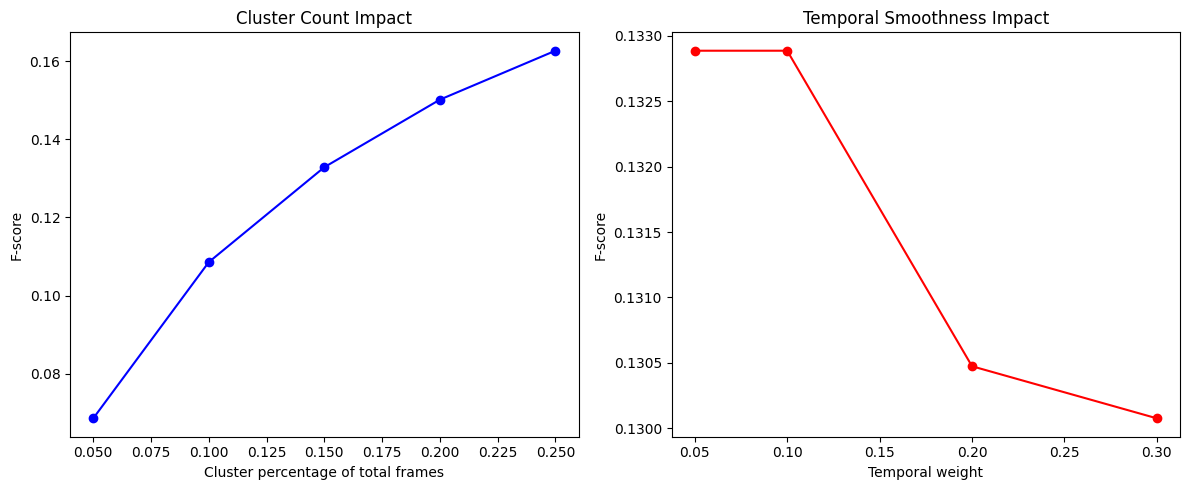


Feature Weight Results:
balanced       : 0.135
motion_heavy   : 0.124
appearance_heavy: 0.140


In [11]:
tune_parameters(video_name, gt_path, feature_dir)

In [12]:
# --- Summary Generation Function ---

def create_summary(video_name, frame_dir, keyframes, output_path="summary.mp4", 
                  skim_duration=1.5, min_gap=2.0):
    """Generate non-overlapping video skims."""
    frame_paths = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])
    fps = 30
    sample_frame = cv2.imread(f"{frame_dir}/{frame_paths[0]}")
    height, width, _ = sample_frame.shape
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    last_end = 0
    for kf in keyframes:
        start = max(last_end, kf - int(fps * skim_duration // 2))
        end = kf + int(fps * skim_duration // 2)
        
        # Ensure no overlap and minimum gap
        if start >= last_end and (start - last_end) >= fps * min_gap:
            for i in range(start, min(end, len(frame_paths))):
                frame = cv2.imread(f"{frame_dir}/{frame_paths[i]}")
                out.write(frame)
            last_end = end
    
    out.release()
    
    out.release()
    print(f"Summary saved to {output_path}")

In [13]:
output_summary_path = os.path.join(summary_dir, f"{video_name}_summary.mp4")
create_summary(video_name, frame_dir, keyframes, output_summary_path)

Summary saved to .\summaries\Saving_dolphines_summary.mp4
